# YOLOv8 Training for Custom Classes

This notebook:
1. Loads the base YOLOv8 model
2. Sets up the dataset with 7 custom classes
3. Trains the model to adapt weights to our classes
4. Displays predictions on test images


In [1]:
# Import required libraries
import os
import yaml
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import torch

# Set matplotlib to inline mode for Jupyter (displays plots in notebook)
%matplotlib inline

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cuda


## 1. Load Base YOLOv8 Model


In [2]:
# Load YOLOv8 (yolov8n.pt explicitly loads YOLOv8, not YOLO11)
model = YOLO('yolov8n.pt')
print("✅ Base YOLOv8 model loaded")


✅ Base YOLOv8 model loaded


## 2. Prepare Dataset for Training


In [3]:
# Prepare dataset.yaml
node_path = Path("data/federated/splits/iid_5nodes/node_1")
data_yaml_path = node_path / "data.yaml"

with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

dataset_config = {
    'path': str(node_path.absolute()),
    'train': 'images',
    'val': 'images',
    'nc': data_config['nc'],
    'names': data_config['names']
}

dataset_yaml = node_path / "dataset.yaml"
with open(dataset_yaml, 'w') as f:
    yaml.dump(dataset_config, f, default_flow_style=False)

print(f"✅ Dataset prepared: {dataset_yaml}")
print(f"   Classes: {data_config['names']}")


✅ Dataset prepared: data\federated\splits\iid_5nodes\node_1\dataset.yaml
   Classes: ['banner', 'erosion', 'hcrack', 'pothole', 'stone', 'trash', 'vcrack']


## 3. Prepare Complete Dataset for Training


In [4]:
# Verify dataset structure
labels_dir = node_path / "labels"
images_dir = node_path / "images"
class_names = data_config['names']

label_files = sorted(list(labels_dir.glob("*.txt")))
image_files = sorted(list(images_dir.glob("*.jpg")))

# Verify matching files
assert len(label_files) == len(image_files), "Mismatch between images and labels"

# Count class distribution
class_counts = {i: 0 for i in range(len(class_names))}
total_boxes = 0

for label_file in label_files:
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                cls_id = int(parts[0])
                if 0 <= cls_id < len(class_names):
                    class_counts[cls_id] += 1
                    total_boxes += 1

print(f"Dataset verified: {len(image_files)} images, {total_boxes} bounding boxes")
print(f"Class distribution:")
for cls_id, count in sorted(class_counts.items()):
    print(f"  {class_names[cls_id]:15s}: {count:5d}")


Dataset verified: 285 images, 659 bounding boxes
Class distribution:
  banner         :    68
  erosion        :    72
  hcrack         :    76
  pothole        :    12
  stone          :     0
  trash          :     3
  vcrack         :   428


## 4. Train Model


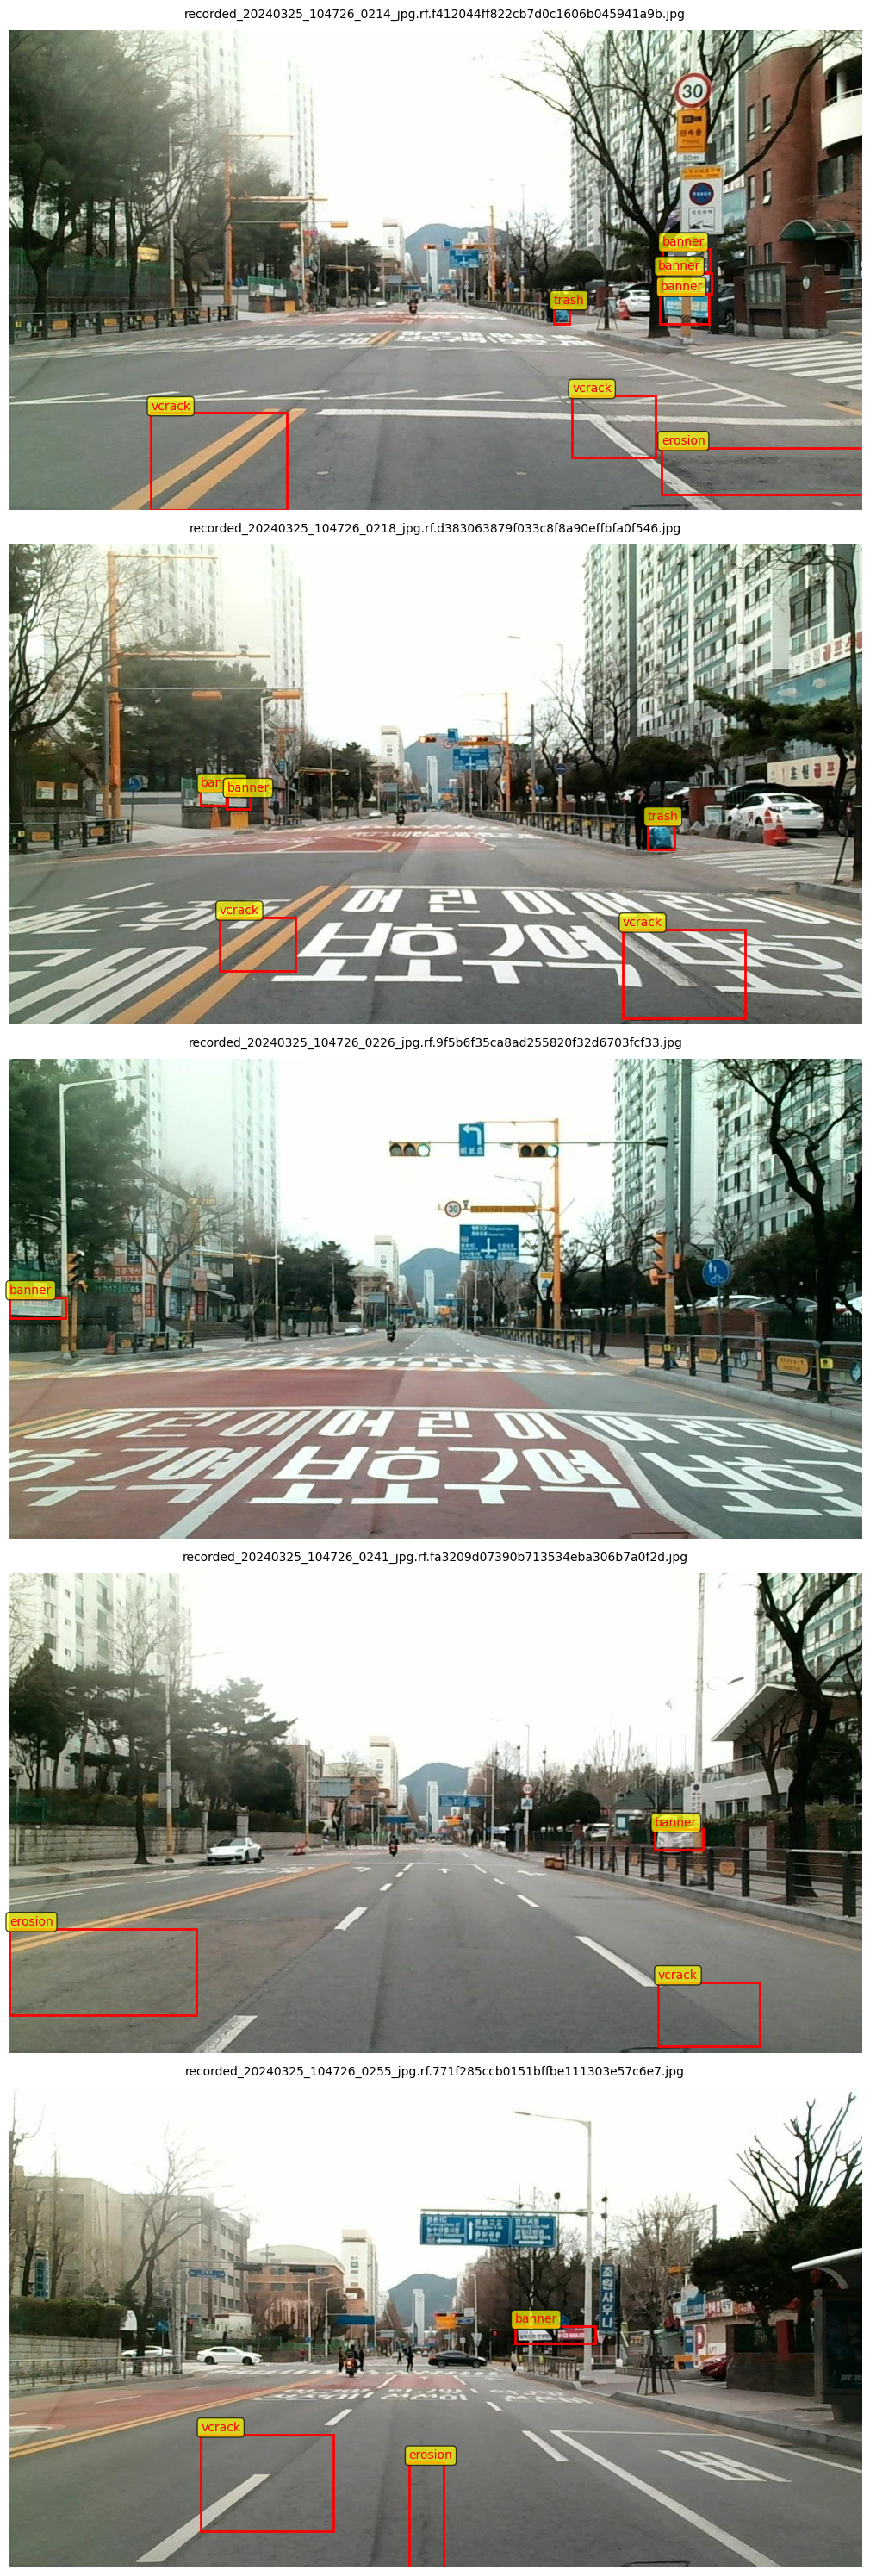

In [5]:
# Visualize 5 random images with bounding boxes
def visualize_annotations(image_path, label_path, class_names, ax):
    img = Image.open(image_path)
    img_width, img_height = img.size
    
    ax.imshow(img)
    ax.axis('off')
    
    # Read and draw bounding boxes
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    cls_id = int(parts[0])
                    x_center = float(parts[1]) * img_width
                    y_center = float(parts[2]) * img_height
                    width = float(parts[3]) * img_width
                    height = float(parts[4]) * img_height
                    
                    # Convert to corner coordinates
                    x1 = x_center - width / 2
                    y1 = y_center - height / 2
                    
                    # Draw bounding box
                    rect = patches.Rectangle((x1, y1), width, height, 
                                           linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)
                    
                    # Add class label
                    label = class_names[cls_id] if cls_id < len(class_names) else f"class_{cls_id}"
                    ax.text(x1, y1 - 5, label, color='red', fontsize=10, 
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

sample_indices = [0,1,2,3,4]

# Display images separately in vertical layout
fig, axes = plt.subplots(5, 1, figsize=(12, 30))
for idx, sample_idx in enumerate(sample_indices):
    image_file = image_files[sample_idx]
    label_file = labels_dir / (image_file.stem + '.txt')
    
    visualize_annotations(image_file, label_file, class_names, axes[idx])
    axes[idx].set_title(image_file.name, fontsize=10, pad=10)

plt.tight_layout()
plt.show()


In [19]:


# Train the model with memory-efficient settings
results = model.train(
    data=str(dataset_yaml),
    epochs=100,
    imgsz=640,
    batch=16,
    device=device,
    project='runs/train',
    name='node1_yolov8',
    exist_ok=True

)


New https://pypi.org/project/ultralytics/8.3.230 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.215  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data\federated\splits\iid_5nodes\node_1\dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False

RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "c:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 41, in do_one_step
    data = pin_memory(data, device)
  File "c:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 75, in pin_memory
    {k: pin_memory(sample, device) for k, sample in data.items()}
  File "c:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 75, in <dictcomp>
    {k: pin_memory(sample, device) for k, sample in data.items()}
  File "c:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 64, in pin_memory
    return data.pin_memory(device)
RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



## 5. Load Trained Model (After Training Completes or Crashes)


In [6]:
# Load the trained model from checkpoint
# Use 'best.pt' for best validation performance, or 'last.pt' for most recent epoch
checkpoint_dir = Path("runs/train/node1_yolov8/weights")
best_model_path = checkpoint_dir / "best.pt"
last_model_path = checkpoint_dir / "last.pt"

# Check which checkpoints exist
if best_model_path.exists():
    print(f"✅ Found best model: {best_model_path}")
    trained_model = YOLO(str(best_model_path))
    print("📊 Using best.pt (best validation performance)")
elif last_model_path.exists():
    print(f"✅ Found last checkpoint: {last_model_path}")
    trained_model = YOLO(str(last_model_path))
    print("📊 Using last.pt (most recent epoch - epoch 91)")
else:
    print("❌ No checkpoint found. Train the model first.")
    trained_model = None


✅ Found best model: runs\train\node1_yolov8\weights\best.pt
📊 Using best.pt (best validation performance)


In [7]:
# Load best model for evaluation
best_model_path = results.save_dir / 'weights' / 'best.pt'
trained_model = YOLO(str(best_model_path))
print(f"✅ Loaded best model: {best_model_path}")


In [8]:
trained_model = YOLO(str(best_model_path))
print(f"✅ Loaded best model: {best_model_path}")

✅ Loaded best model: C:\Users\muham\OneDrive\Desktop\Uni\Projects\federated-health-risk-mlops\runs\train\node1_yolov8\weights\best.pt


## 6. Model Evaluation


In [7]:
# Validate model
metrics = trained_model.val(data=str(dataset_yaml))
print(f"\n📊 Validation Metrics:")
print(f"   mAP50: {metrics.box.map50:.4f}")
print(f"   mAP50-95: {metrics.box.map:.4f}")
print(f"   Precision: {metrics.box.mp:.4f}")
print(f"   Recall: {metrics.box.mr:.4f}")


Ultralytics 8.3.215  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 165.136.7 MB/s, size: 95.5 KB)
val: Scanning C:\Users\muham\OneDrive\Desktop\Uni\Projects\federated-health-risk-mlops\data\federated\splits\iid_5nodes\node_1\labels.cache... 285 images, 101 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 285/285 284.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.4it/s 2.1s<0.2s
                   all        285        659      0.816      0.769      0.827      0.555
                banner         16         68      0.744      0.956      0.938      0.665
               erosion         45         72      0.732      0.944       0.96      0.689
                hcrack         41         76      0.726      0.418      0.614      0.327
               pothole

## 7. Confusion Matrix


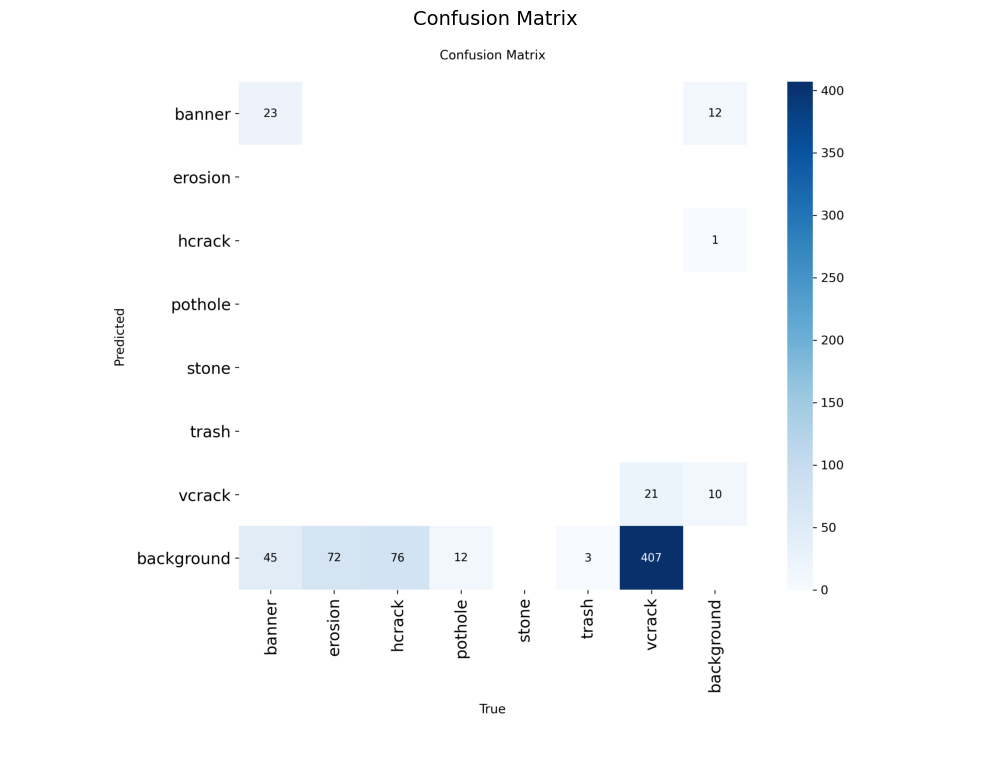

In [10]:
# Plot confusion matrix
confusion_matrix_path = results.save_dir / 'confusion_matrix.png'
if confusion_matrix_path.exists():
    img = Image.open(confusion_matrix_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Confusion Matrix', fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()


## 8. Visualize Predictions on Sample Images


image 1/1 c:\Users\muham\OneDrive\Desktop\Uni\Projects\federated-health-risk-mlops\data\federated\splits\iid_5nodes\node_1\images\recorded_20240325_104726_0214_jpg.rf.f412044ff822cb7d0c1606b045941a9b.jpg: 384x640 4 banners, 1 erosion, 1 trash, 2 vcracks, 74.8ms
Speed: 2.7ms preprocess, 74.8ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\Users\muham\OneDrive\Desktop\Uni\Projects\federated-health-risk-mlops\data\federated\splits\iid_5nodes\node_1\images\recorded_20240325_104726_0218_jpg.rf.d383063879f033c8f8a90effbfa0f546.jpg: 384x640 3 banners, 1 trash, 2 vcracks, 77.0ms
Speed: 7.8ms preprocess, 77.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\Users\muham\OneDrive\Desktop\Uni\Projects\federated-health-risk-mlops\data\federated\splits\iid_5nodes\node_1\images\recorded_20240325_104726_0226_jpg.rf.9f5b6f35ca8ad255820f32d6703fcf33.jpg: 384x640 1 banner, 7.6ms
Speed: 1.1ms preprocess, 7.6ms inference, 1.9ms postprocess pe

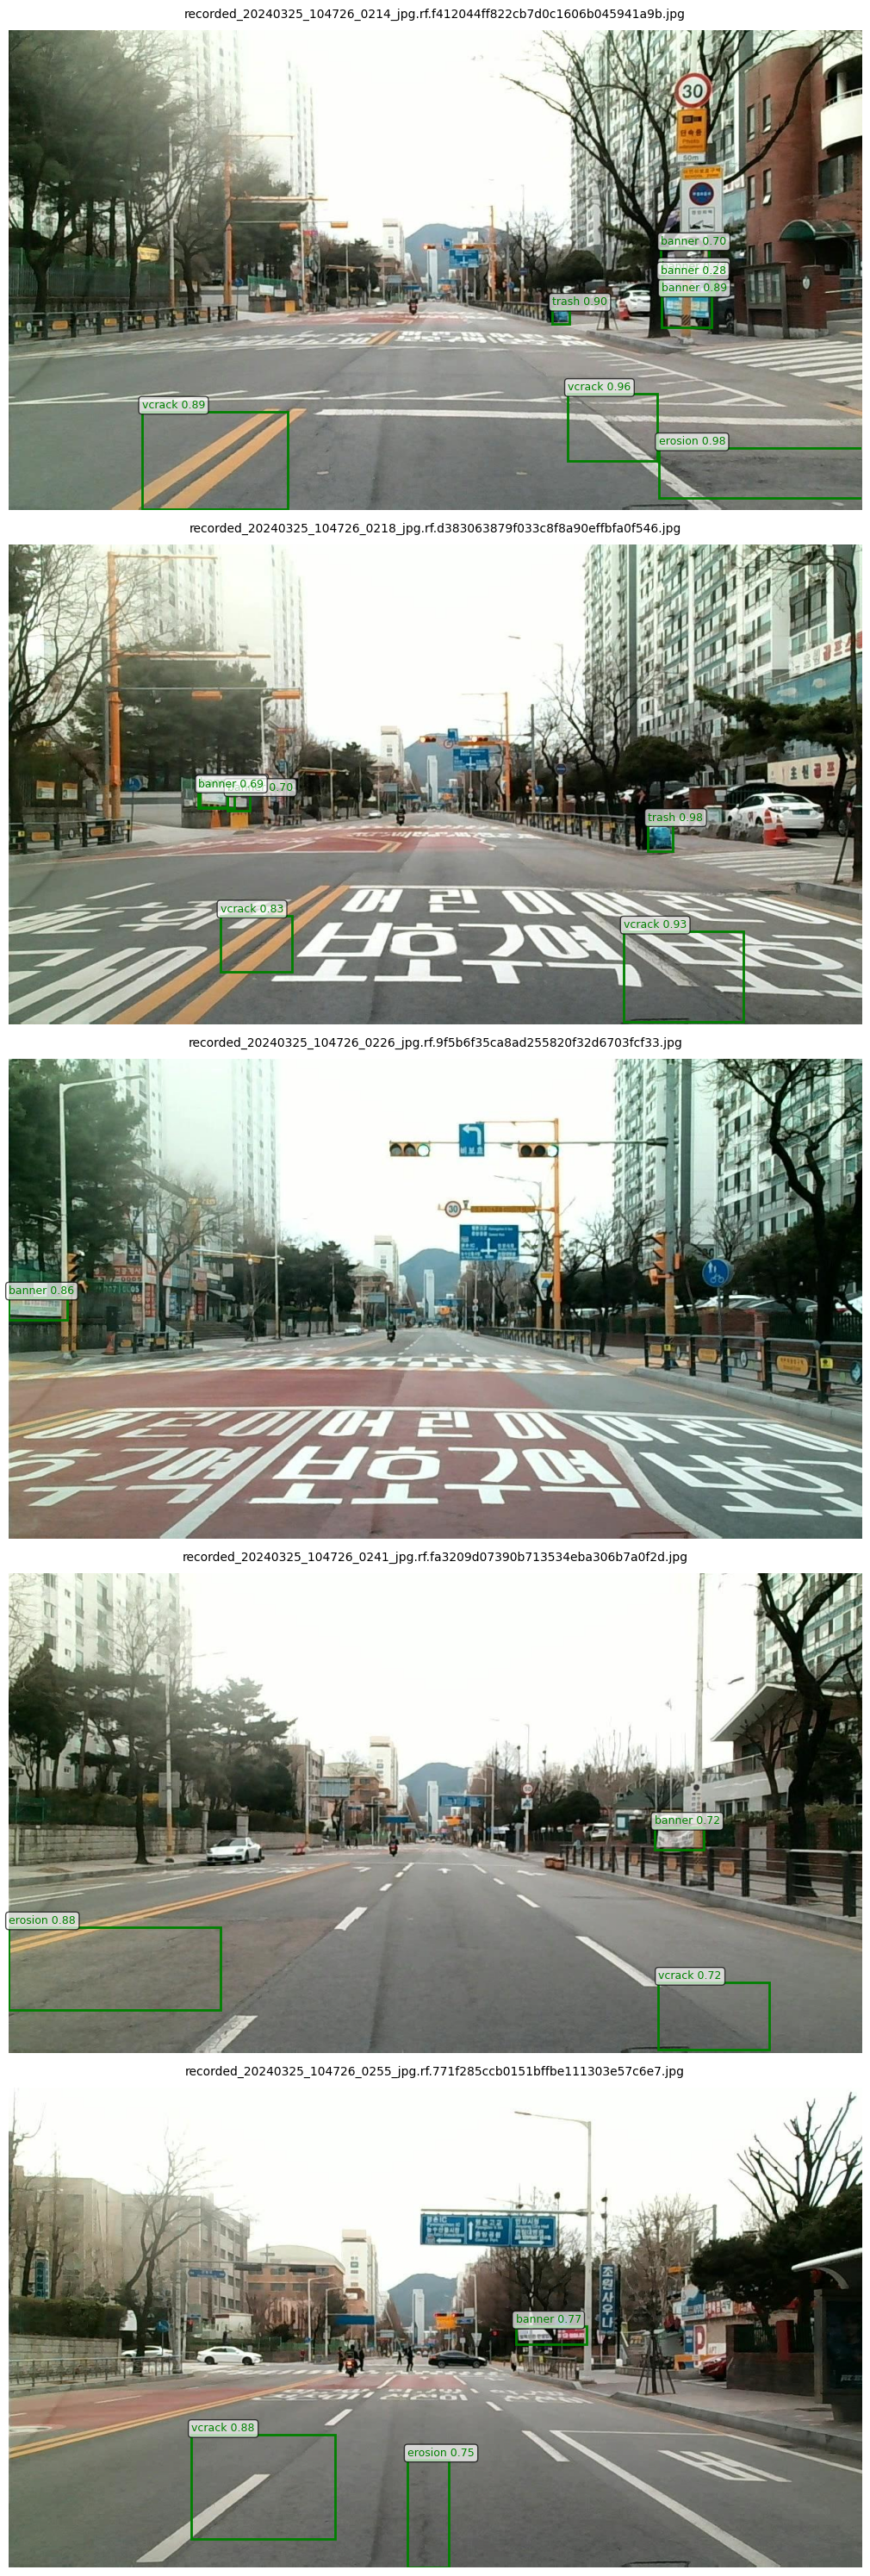

In [8]:
# Predict on first 5 images
sample_images = image_files[:5]
fig, axes = plt.subplots(5, 1, figsize=(12, 30))

for idx, image_file in enumerate(sample_images):
    results_pred = trained_model.predict(str(image_file), conf=0.25)
    
    img = Image.open(image_file)
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(image_file.name, fontsize=10, pad=10)
    
    # Draw predictions
    for r in results_pred:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())
            
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   linewidth=2, edgecolor='green', facecolor='none')
            axes[idx].add_patch(rect)
            
            label = f"{class_names[cls]} {conf:.2f}"
            axes[idx].text(x1, y1 - 5, label, color='green', fontsize=9,
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()
